In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# 幫助安裝一些需要的package和開啟和Google Drive連動的權限
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.21-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
# 上傳/下載至Google Drive
# 以下兩段程式碼功能分別為上傳和下載檔案。
# 第一段程式碼執行後會在該cell輸出中顯示按鈕，就可以從本機上選擇檔案，上傳後是傳到虛擬機中。
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "test.csv" with length 420783 bytes
User uploaded file "train.csv" with length 987712 bytes


In [0]:
!pip install transformers

     |████████████████████████████████| 665kB 15.1MB/s 
     |████████████████████████████████| 890kB 17.6MB/s 
     |████████████████████████████████| 1.1MB 40.2MB/s 
     |████████████████████████████████| 3.8MB 43.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c8a44e1146c7921f22a1bd9c1470041bb07ecde3a6d6d02137f3314b8361545d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as K
import seaborn as sns
import transformers
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

plt.style.use('seaborn')

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
print(tf.__version__)

2.2.0


# 資料清理---使用正則表達式

In [0]:
def clean(text):
    # 移除顏文字和一些怪符號
    reg = re.compile('\\.+?(?=\B|$)')
    text = text.apply(lambda r: re.sub(reg, string = r, repl = ''))
    reg = re.compile('\x89Û_')
    text = text.apply(lambda r: re.sub(reg, string = r, repl = ' '))
    reg = re.compile('\&amp')
    text = text.apply(lambda r: re.sub(reg, string = r, repl = '&'))
    reg = re.compile('\\n')
    text = text.apply(lambda r: re.sub(reg, string = r, repl = ' '))
    # 移除 hashtag 的符號'#'
    text = text.apply(lambda r: r.replace('#', ''))
    # 移除人名標記
    reg = re.compile('@\w+')
    text = text.apply(lambda r: re.sub(reg, string = r, repl = '@'))
    # 移除網址
    reg = re.compile('https?\S+(?=\s|$)')
    text = text.apply(lambda r: re.sub(reg, string = r, repl = 'www'))
    # 全部小寫化
    text = text.apply(lambda r: r.lower())
    return text

In [0]:
train['cleaned'] = clean(train['text'])
test['cleaned'] = clean(test['text'])

In [0]:
train.head()

,id,keyword,location,text,target,cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [0]:
from transformers import TFXLNetModel, XLNetTokenizer

In [0]:
# This is the identifier of the model,
# which is required for downloading the weights
# and initialize the architecture
model = 'xlnet-large-cased'
tokenizer = XLNetTokenizer.from_pretrained(model)

# 建造模型

In [0]:
def modeling(name):
    """
    Create the model, which is composed of the XLNet main block
    and then a classification head added.
    """
    
    
    # 定義輸入，為120維的token之id，也就是我們取120字
    inputs = K.Input(shape = (120, ), name = 'inputs', dtype = 'int32')
    
    # 匯入XLNet模型
    xlnet = TFXLNetModel.from_pretrained(name)
    #xlnet.trainable = False
    xlnet_encodings = xlnet(inputs)[0]
    print(xlnet_encodings)
    
    # 分類頭(Classification head)
    # CLS部分(就是所謂Collect last step from Last hidden State)
    doc_encodings = tf.squeeze(xlnet_encodings[:, -1:, :], axis = 1)
    # 採用dropout以正則化(regularization)，防止過擬合(overfitting)
    doc_encodings = K.layers.Dropout(0.1)(doc_encodings)
    # 最終的輸出
    outputs = K.layers.Dense(1, activation = 'sigmoid', name = 'outputs')(doc_encodings)
    
    #組裝模型
    model = K.Model(inputs = [inputs], outputs = [outputs])
    # 把梯度問題~~~!!
    
    model.compile(optimizer = K.optimizers.Adam(lr = 2e-5), loss = 'binary_crossentropy',
                 metrics = ['accuracy', K.metrics.Precision(), K.metrics.Recall()])
    # Precision是準確率 = TP / (TP + FP)
    # Recall是召回率 = TP / (TP + FN)
    
    return model

In [0]:
xlnet = modeling(model)

Tensor("tfxl_net_model_1/Identity:0", shape=(None, 120, 1024), dtype=float32)


In [0]:
xlnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 120)]             0         
_________________________________________________________________
tfxl_net_model_1 (TFXLNetMod ((None, 120, 1024),)      360268800 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 1, 1024)]         0         
_________________________________________________________________
tf_op_layer_Squeeze_1 (Tenso [(None, 1024)]            0         
_________________________________________________________________
dropout_147 (Dropout)        (None, 1024)              0         
_________________________________________________________________
outputs (Dense)              (None, 1)                 1025      
Total params: 360,269,825
Trainable params: 360,269,825
Non-trainable params: 0
_____________________________________________

# 分割資料、生成張量、畫ROC圖

In [0]:
# 針對訓練集，再將其分割一部分(此設15%)，作為測試集
# 可以想像是做模擬考，而真正的test.csv則是正式的大考
x_train, x_test, y_train, y_test = train_test_split(train['cleaned'], train['target'], test_size = 0.15, random_state = 150)

In [0]:
# 使用給定的tokenizer來從文字內容中，生成由token之id組成的120維tensor
def get_inputs(texts, tokenizer, max_len = 120):
    inputs = [tokenizer.encode_plus(t, max_length = max_len, pad_to_max_length = True, add_special_token = True) for t in texts]
    inp_tokens = np.array([i['input_ids'] for i in inputs])
    indexes = np.array([i['attention_mask'] for i in inputs])
    segments = np.array([i['token_type_ids'] for i in inputs])
    return inp_tokens, indexes, segments

In [0]:
# 以下這個函數用來使學習率緩慢增加
# 如此會有更好的收斂效果
# 但我們採取的是fine-tunning，所以其實不太重要...
def slowly(epoch, lr):
    return max(lr + 1e-6, 2e-5)

In [0]:
# 以下為畫ROC圖的函數，使用準確率與AUC畫
def plot_ROC(prediction, label):
    acc = accuracy_score(label, np.array(prediction.flatten() >= 0.5, dtype = 'int'))
    FP, TP, thresholds = roc_curve(label, prediction)
    # 看ROC圖曲線下面積，介於0~1之間
    # 值越高表示準確率越高，0.5以下表示模型沒用
    auc = roc_auc_score(label, prediction)
    #以下畫圖
    figure, ax = plt.subplots(1, figsize = (10, 10))
    ax.plot(FP, TP, color = 'red')
    ax.plot([0,1], [0,1], color = 'black', linestyle = '--')
    ax.set_title(f"曲線下面積AUC為：{auc}\n準確率ACC為：{acc}")
    return figure

In [0]:
# 生成輸入的張量(tensor)
inp_tokens, indexes, segments = get_inputs(x_train, tokenizer)

# 開始訓練！

### 定義各個回調函數，用逗號隔開

In [0]:
callbacks = [
    # 監控測試集的準確率，若該準確率連續三回合沒提升，就停止訓練。過程中只保存在測試集中表現最好的模型(權重)
    K.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3, min_delta = 0.02, restore_best_weights = True),
    # 學習率動態調整，使用剛剛的自訂函數slowly調整，不印出該動作訊息
    K.callbacks.LearningRateScheduler(slowly, verbose = 0),
    # 如果連續2個epoch模型性能沒提升，就嘗試減少學習率lr，每次減少lr*1e-6，不印出該動作訊息
    # 學習率減少後，不進行cooldown,。學習率下限為0
    K.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 1e-6, patience = 2,
                                  verbose = 0, mode = 'auto', min_delta = 0.001, cooldown = 0, min_lr = 1e-6)
]

### 開始訓練

In [0]:
type(y_train)

pandas.core.series.Series

In [0]:
y_train = np.array(y_train)

In [0]:
#history = xlnet.fit(x = inp_tokens, y = y_train, epochs = 2, batch_size = 20, validation_split = 0.15, callbacks = callbacks)
# ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[2304,384]
#	 [[Node: ExponentialMovingAverage/AssignMovingAvg_4/sub_1 = Sub[T=DT_FLOAT, _class=["loc:@local3/weights"], _device="/job:localhost/replica:0/task:0/cpu:0"](local3/weights/ExponentialMovingAverage/read, local3/weights/read)]]
# The most expedient way is probably to reduce the batch size. It'll run slower, but use less memory.
# sol: 降 batch_size
history = xlnet.fit(x = inp_tokens, y = y_train, epochs = 2, batch_size = 5, validation_split = 0.15, callbacks = callbacks)

Epoch 1/2
1100/1100 [==============================] - 646s 587ms/step - loss: 0.9497 - accuracy: 0.5689 - precision_1: 0.4995 - recall_1: 0.4588 - val_loss: 0.6581 - val_accuracy: 0.6365 - val_precision_1: 0.9079 - val_recall_1: 0.1663 - lr: 2.2000e-05
Epoch 2/2
1100/1100 [==============================] - 642s 584ms/step - loss: 0.5763 - accuracy: 0.7405 - precision_1: 0.7197 - recall_1: 0.6513 - val_loss: 0.4518 - val_accuracy: 0.8095 - val_precision_1: 0.8710 - val_recall_1: 0.6506 - lr: 2.3000e-05


# 測試

In [0]:
inp_tokens, indexes, segments = get_inputs(x_test, tokenizer)

In [0]:
prediction = xlnet.predict(inp_tokens, verbose = True)

36/36 [==============================] - 37s 1s/step


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32218 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28858 missing from current font.
  font.set_

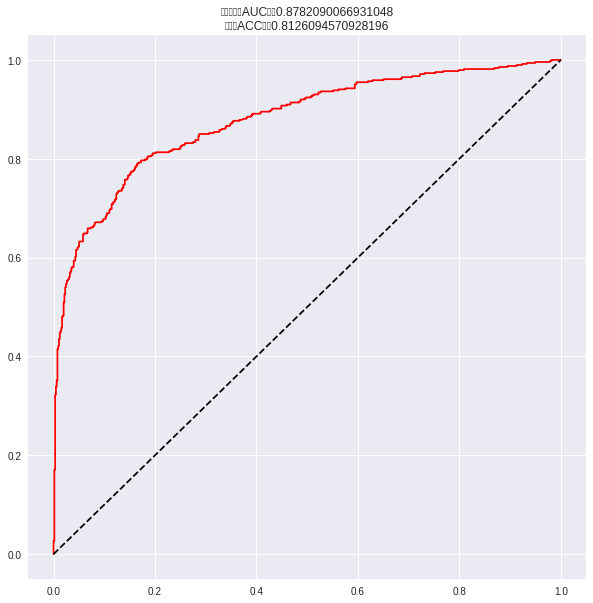

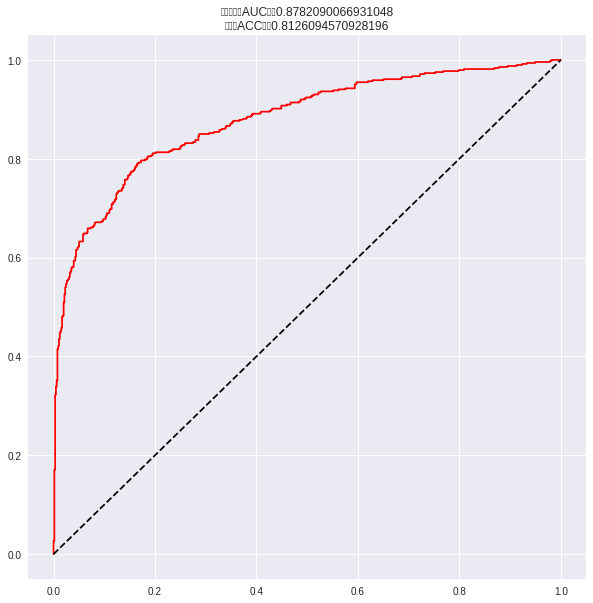

In [0]:
plot_ROC(prediction, y_test)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32218 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28858 missing from current font.
  font.set_

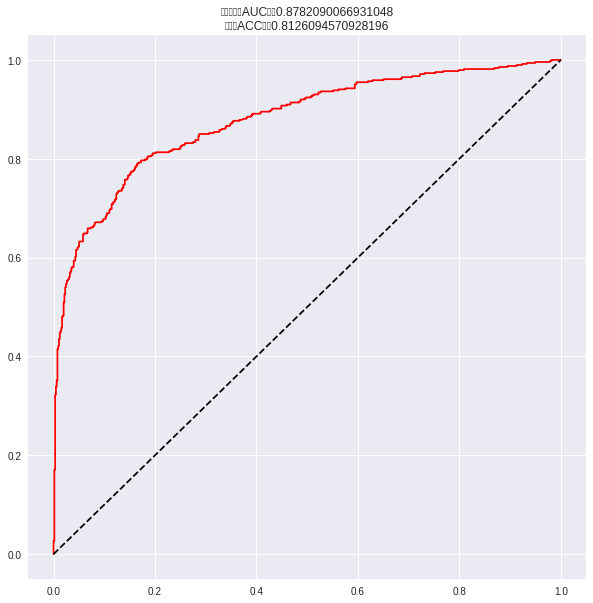

In [0]:
ax = plot_ROC(prediction, y_test)

In [0]:
import matplotlib
import matplotlib.pyplot as plt

ax.savefig('plot.png')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32218 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28858 missing from current font.
  font.set_

In [0]:
plot_ROC

<function __main__.plot_ROC>

In [0]:
type(prediction)

numpy.ndarray

In [0]:
prediction.shape

(1142, 1)

In [0]:
prediction

array([[0.46272597],
       [0.4921045 ],
       [0.19519143],
       ...,
       [0.19028868],
       [0.2239368 ],
       [0.6088351 ]], dtype=float32)

In [0]:
df = pd.DataFrame({"predicted": prediction.tolist()})

In [0]:
df

,predicted
0,[0.462725967168808]
1,[0.49210450053215027]
2,[0.1951914280653]
3,[0.8771395087242126]
4,[0.16083350777626038]
...,...
1137,[0.32202765345573425]
1138,[0.4518525302410126]
1139,[0.19028867781162262]
1140,[0.2239367961883545]


In [0]:
##Why the fails?

In [0]:
pred_analysis_df = pd.DataFrame({'tweet':x_test.values, 'pred':prediction.flatten(), 'real':y_test})
pred_analysis_df['rounded'] = np.array(pred_analysis_df['pred'] > 0.5, dtype='int')
diff = pred_analysis_df[pred_analysis_df['real'] != pred_analysis_df['rounded']]

In [0]:
#change to see other examples
idx = 44

tweet, real, pred = diff.iloc[idx, [0,2,3]]
print(tweet)
print("PRED: " + str(pred))
print("REAL: " + str(real))

burford what a catastrophe! traffic and big lorries no action as usual from council
PRED: 1
REAL: 0


In [0]:
tweets = test['cleaned']
inp_tok, ids, segments = get_inputs(tweets, tokenizer)

In [0]:
preds = xlnet.predict(inp_tok, verbose=True)

102/102 [==============================] - 106s 1s/step


In [0]:
test['target'] = preds
test['target'] = np.array(test['target'] >= 0.5, dtype='int')
test[['id', 'target']].to_csv('submission_XLNet0526_colab不凍結bs=5.csv', index=False)
# submission_XLNet0526_colab.csv
# submission_XLNet0526_colab不凍結bs=5.csv

df.to_csv('df_pred_XLNet0526格式不對.csv', sep = ',', index = False)

In [0]:
# 儲存權重

model_1.save_weights('./submission_XLNet0526_colab不凍結bs=5.h5.h5', overwrite=True)
# new_model = make_model(batch_size=None)
# new_model.load_weights('./tpu.h5')
# new_model.summary()
# new_model.evaluate(x_test, y_test)
# ————————————————
# 版权声明：本文为CSDN博主「big91987」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/big91987/java/article/details/87898100

NameError: ignored